In [1]:
import matplotlib.pyplot as plt
import numpy as np
!pip3 install matplotlib numpy PyQt5


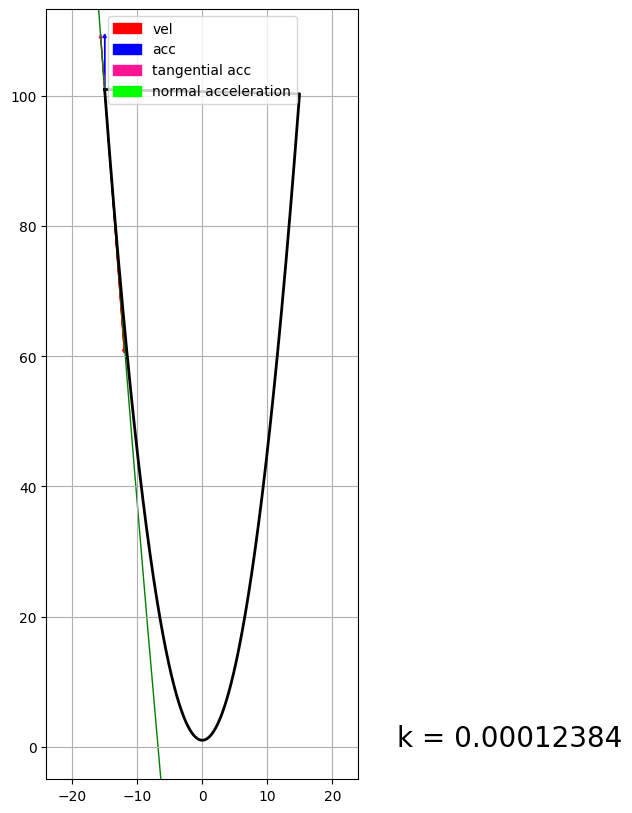

In [2]:
from dataclasses import dataclass
from typing import List
from matplotlib.animation import FuncAnimation

FPS = 60  # increase to make animation slower
t_start = -5.0
t_end = 5.0
frames = int((t_end - t_start) * FPS)


def fx(t):
    return t * 3


def fy(t):
    return t * t * 4 + 1


# function computes current sim time by frame number
def t(i):
    return t_start + i / FPS


# class take core of storing data points we computed in animation
@dataclass
class TracePoint:
    x: float
    y: float
    t: float

    vel: np.array
    acc: np.array

    @property
    def accn(self):
        # nothing special, just normal acceleration as difference
        return self.acc - self.acct

    @property
    def acct(self):
        # tangential acceleration is aligned with velocity vector
        acct = np.dot(self.acc, self.vel / np.linalg.norm(self.vel))
        return acct * self.vel / np.linalg.norm(self.vel)

    @property
    def k(self):
        # in original formula there are derivatives,
        # but in our sense they are just acceleration and veloctiy
        return np.linalg.norm(self.acc) / (np.sqrt(1 + self.vel.dot(self.vel))) ** 3

    @property
    def osculating_center(self):
        # i'm not a genius in math, but i think this is correct
        # http://mathonline.wikidot.com/the-osculating-circle-at-a-point-on-a-curve
        radius = 1 / self.k
        # find center of osculating center
        tan = self.vel / np.linalg.norm(self.vel)  # tangent
        b = np.cross(self.vel, self.acc)  # binormal
        n = np.cross(b, tan)  # normal
        n = n / np.linalg.norm(n)
        return np.array([self.x, self.y, 0]) + radius * n


# nothing will be interesting later, just initalization of plot

trace: List[TracePoint] = []

fig, ax = plt.subplots(figsize=(10, 10))
ax.set(xlim=(-24, 24), ylim=(-5, 4 / 9 * 15 * 17))
ax.set_aspect("equal")
ax.grid()


line = ax.plot([], [], color="k", lw=2)[0]
# display velocity vector
vel = ax.arrow(0, 0, 0, 0, head_width=0.5, head_length=0.5, color="r", label="vel")
acc = ax.arrow(0, 0, 0, 0, head_width=0.5, head_length=0.5, color="b", label="acc")
acct = ax.arrow(
    0,
    0,
    0,
    0,
    head_width=0.5,
    head_length=0.5,
    color="deeppink",
    label="tangential acc",
)
accn = ax.arrow(
    0,
    0,
    0,
    0,
    head_width=0.5,
    head_length=0.5,
    color="lime",
    label="normal acceleration",
)

ktext = ax.text(30, 0, "", color="k", fontsize=20)

osculatingCircle = plt.Circle((0, 0), 5, color="g", fill=False)
ax.add_patch(osculatingCircle)
ax.legend()


def animate(i):
    ti = t(i)
    trace.append(
        TracePoint(
            x=fx(ti),
            y=fy(ti),
            t=ti,
            vel=np.array([3, 8 * ti, 0]),
            acc=np.array([0, 8, 0]),
        )
    )

    last = trace[-1]
    line.set_xdata([p.x for p in trace])
    line.set_ydata([p.y for p in trace])

    vel.set_data(x=last.x, dx=last.vel[0], y=last.y, dy=last.vel[1])
    acc.set_data(x=last.x, dx=last.acc[0], y=last.y, dy=last.acc[1])
    acct.set_data(x=last.x, dx=last.acct[0], y=last.y, dy=last.acct[1])
    accn.set_data(x=last.x, dx=last.accn[0], y=last.y, dy=last.accn[1])

    osculatingCircle.set_radius(1 / last.k)
    osculatingCircle.set_center(last.osculating_center)

    ktext.set_text(f"k = {last.k:.8f}")


anim = FuncAnimation(fig, animate, interval=1, frames=frames)
anim.save("motion_task1.gif")
plt.draw()
plt.show()


In [3]:
from dataclasses import dataclass
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches

FPS = 60 # increase to make animation slower
phi_start = 0.0
phi_end = 2 * np.pi
frames = int((phi_end - phi_start) * FPS)


def phi(i):
    return phi_start + i / FPS


OA = 25
OP = 25
AB = 80
AC = 20
x = np.pi / 3
w = 1


@dataclass
class SystemTrace:
    phi: float

    @property
    def apos(self):
        return np.array(
            [
                OA * np.sin(self.phi),
                OA * np.cos(self.phi),
                0,
            ]
        )

    @property
    def avel(self):
        return np.array(
            [
                OA * np.cos(self.phi) * w,
                -OA * np.sin(self.phi) * w,
                0,
            ]
        )

    @property
    def aacc(self):
        return np.array(
            [
                -OA * np.sin(self.phi) * w,
                -OA * np.cos(self.phi) * w,
                0,
            ]
        )

    @property
    def aacct(self):
        return (
            np.dot(self.aacc, self.avel)
            / np.linalg.norm(self.avel)
            * self.avel
            / np.linalg.norm(self.avel)
        )

    @property
    def aaccn(self):
        return self.aacc - self.aacct

    @property
    def bpos(self):
        # I have chosen vector form of calculating kinematics
        y = np.arccos((OP * np.cos(np.pi / 6) - OA * np.cos(self.phi)) / AB)

        return np.array(
            [
                OA * np.sin(self.phi) + AB * np.sin(y),
                OP * np.cos(np.pi / 6),
                0,
            ]
        )

    @property
    def bvel(self):
        # haha I'm mathemagician https://www.derivative-calculator.net/

        A = OA
        B = AB
        c = np.cos(self.phi)
        s = np.sin(self.phi)

        com = np.cos(np.pi / 6) - c

        return np.array(
            [
                A * c - (A**2 * (com) * s) / np.sqrt(B**2 - A**2 * com**2),
                0,
                0,
            ]
        )


    @property
    def bacc(self):
        # do you really want to see something impressive??
        # https://www.derivative-calculator.net/
        A = OA
        B = AB
        c = np.cos(self.phi)
        s = np.sin(self.phi)

        com = np.cos(np.pi / 6) - c

        x = (
            (-(A**2) * s**2 - A**2 * c * com)
            / np.sqrt(B**2 - A**2 * com**2)
            - (A**4 * s**2 * com**2) / ((B**2 - A**2 * com**2) ** 1.5)
            - A * s
        )

        return np.array([x, 0, 0])

    @property
    def cpos(self):
        a, b = self.apos, self.bpos
        # as AC is 20 and AB is 80, we can use the ratio to find the position of C
        return a + (b - a) * AC / AB

    @property
    def cvel(self):
        return self.avel + (self.bvel - self.avel) * AC / AB

    @property
    def cacc(self):
        return self.aacc + (self.bacc - self.aacc) * AC / AB

    @property
    def cacct(self):
        # tangential acceleration is aligned with velocity
        x, y = self.cacc, self.cvel
        return y * np.dot(x, y) / np.dot(y, y)

    @property
    def caccn(self):
        return self.cacc - self.cacct

# nothing intersting later, just plotting

traces: List[SystemTrace] = []

fig, ax = plt.subplots(figsize=(10, 10))
ax.set(xlim=(-50, 120), ylim=(-30, 100))
ax.set_aspect("equal")
ax.grid()

p = SystemTrace(0)
point_a = ax.arrow(
    0,
    0,
    p.apos[0],
    p.apos[1],
    head_width=0.9,
    head_length=0.5,
    color="b",
    lw=1.5,
)
point_b = ax.arrow(
    p.apos[0],
    p.apos[1],
    p.bpos[0] - p.apos[0],
    p.bpos[1] - p.apos[1],
    head_width=0.9,
    head_length=0.5,
    color="r",
    lw=1.5,
)

box_b = patches.Rectangle((0, 0), 15, 8, linewidth=1, edgecolor="r", facecolor="none")
ax.add_patch(box_b)
vel_b = ax.arrow(
    p.bpos[0],
    p.bpos[1],
    p.bvel[0],
    p.bvel[1],
    color="c",
    label="B velocity",
    lw=0.5,
)
acc_b = ax.arrow(
    p.bpos[0],
    p.bpos[1],
    p.bacc[0],
    p.bacc[1],
    color="m",
    label="B acceleration",
)

point_c = plt.Circle((0, 0), 1, color="green", label="point C")
ax.add_patch(point_c)
vel_c = ax.arrow(
    p.cpos[0],
    p.cpos[1],
    p.cvel[0],
    p.cvel[1],
    color="y",
    label="C velocity",
)

acc_c = ax.arrow(
    p.cpos[0],
    p.cpos[1],
    p.cacc[0],
    p.cacc[1],
    color="cyan",
    label="C acceleration",
)
acc_c_t = ax.arrow(
    p.cpos[0],
    p.cpos[1],
    p.cacct[0],
    p.cacct[1],
    color="lime",
    label="C tangential acceleration",
)
acc_c_n = ax.arrow(
    p.cpos[0],
    p.cpos[1],
    p.caccn[0],
    p.caccn[1],
    color="deeppink",
    label="C normal acceleration",
)

txt = plt.text(-50, -80, "this is something")
fig.add_artist(txt)
txt.update(
    {
        "text": f"""\
    angle: {0:.2f}\n
    apos: {p.apos}\n
    avel: {p.avel}\n
    aacc: {p.aacc}\n
    aacct: {p.aacct}\n
    bpos: {p.bpos}\n
    bvel: {p.bvel}\n
    bacc: {p.bacc}\n
    cpos: {p.cpos}\n
    cvel: {p.cvel}\n
    cacc: {p.cacc}\n
        """
    }
)


np.set_printoptions(formatter={"float": "{: 0.3f}".format})


def animate(i):
    angle = phi(i)
    traces.append(SystemTrace(angle))

    p = traces[-1]
    point_a.set_data(x=0, dx=p.apos[0], y=0, dy=p.apos[1])

    box_b.set_xy((p.bpos - np.array([15, 8, 0]) / 2)[:2])
    point_b.set_data(
        x=p.apos[0], dx=p.bpos[0] - p.apos[0], y=p.apos[1], dy=p.bpos[1] - p.apos[1]
    )
    vel_b.set_data(x=p.bpos[0], dx=p.bvel[0], y=p.bpos[1], dy=p.bvel[1])
    acc_b.set_data(x=p.bpos[0], dx=p.bacc[0], y=p.bpos[1], dy=p.bacc[1])

    point_c.set_center(p.cpos)
    vel_c.set_data(x=p.cpos[0], dx=p.cvel[0], y=p.cpos[1], dy=p.cvel[1])

    acc_c.set_data(x=p.cpos[0], dx=p.cacc[0], y=p.cpos[1], dy=p.cacc[1])
    acc_c_t.set_data(x=p.cpos[0], dx=p.cacct[0], y=p.cpos[1], dy=p.cacct[1])
    acc_c_n.set_data(x=p.cpos[0], dx=p.caccn[0], y=p.cpos[1], dy=p.caccn[1])

    txt.update(
        {
            "text": f"""\
        angle: {angle:.2f}\n
        apos: {p.apos}\n
        bpos: {p.bpos}    bvel: {p.bvel}    bacc: {p.bacc}\n
        cpos: {p.cpos}    cvel: {p.cvel}    cacc: {p.cacc}\n
        caccn: {p.caccn}    cacct: {p.cacct}\n
"""
        }
    )


anim = FuncAnimation(fig, animate, interval=1, frames=frames)
plt.legend()
anim.save("motion_task2.gif")
plt.draw()
plt.show()
